In [192]:
%matplotlib inline

# Лабораторная работа №1, часть 1

In [ ]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

## Загрузка данных

In [194]:
POPULATION_COLUMN_NAME = "population"
PROFIT_COLUMN_NAME = "profit"

COLUMN_NAMES = (POPULATION_COLUMN_NAME, PROFIT_COLUMN_NAME)

DATA_TYPE = np.float32

data = pd.read_csv(
    "./ex1data1.txt", sep=",", header=None, names=COLUMN_NAMES, dtype=DATA_TYPE
)

POPULATIONS = data[POPULATION_COLUMN_NAME]
PROFITS = data[PROFIT_COLUMN_NAME]

print(data)

    population     profit
0       6.1101  17.591999
1       5.5277   9.130200
2       8.5186  13.662000
3       7.0032  11.854000
4       5.8598   6.823300
..         ...        ...
92      5.8707   7.202900
93      5.3054   1.986900
94      8.2934   0.144540
95     13.3940   9.055100
96      5.4369   0.617050

[97 rows x 2 columns]


## График зависимости прибыли ресторана от населения города, в котором он расположен

In [195]:
approximation_fig, approximation_axes = plt.subplots()

approximation_axes.scatter(
    data[COLUMN_NAMES[0]], data[COLUMN_NAMES[1]], color="blue", marker="x"
)
approximation_axes.set_xlabel("Population")
approximation_axes.set_ylabel("Profit")


Text(0, 0.5, 'Profit')

## Функция потерь

$$
\begin{equation*}
\large
J(\theta) = \dfrac {1}{2m} \displaystyle \sum _{i=1}^m
\left (h_\theta (x^{(i)}) - y^{(i)}
\right)^2, \\
где \, h_\theta(x) = \theta_0 + \theta_1 x
\end{equation*}
$$

In [196]:

def hypothesis(theta_0: DATA_TYPE, theta_1: DATA_TYPE, x: DATA_TYPE):
    return theta_0 + theta_1 * x


def loss(theta_0, theta_1, x, y):
    """Mean squared error"""

    length = len(x)
    assert length == len(y)

    return sum(
        (hypothesis(theta_0, theta_1, x_i) - y_i) ** 2 for x_i, y_i in zip(x, y)
    ) / DATA_TYPE(length * 2)


## Частные производные функции потерь

$$
\begin{align*}
\frac {\partial}{\partial \theta_0}J(\theta) =
\frac{1}{m} \sum\limits_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)}) \\
\frac {\partial}{\partial \theta_1}J(\theta) =
\frac{1}{m} \sum\limits_{i=1}^{m}((h_\theta(x^{(i)}) - y^{(i)})x^{(i)})
\end{align*}
$$

## Градиентный спуск

$$
\begin{align*}
\theta_0 = \theta_0 - \alpha\frac {\partial}{\partial \theta_0}J(\theta)
= \theta_0 - \alpha\frac{1}{m} \sum\limits_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})\\
\theta_1 = \theta_1 - \alpha\frac {\partial}{\partial \theta_1}J(\theta)
= \theta_1 - \alpha\frac{1}{m} \sum\limits_{i=1}^{m}((h_\theta(x^{(i)})
- y^{(i)})x^{(i)}),
\end{align*}\\
где \, \alpha - коэффициент \, скорости \, обучения.
$$

In [197]:

def new_params_gen(theta_0, theta_1, x, y, learning_rate):
    """Generate new parameters"""
    length = len(x)
    assert length == len(y)

    while True:
        new_theta_0 = theta_0 - learning_rate * sum(
            hypothesis(theta_0, theta_1, x_i) - y_i for x_i, y_i in zip(x, y)
        ) / DATA_TYPE(length)
        new_theta_1 = theta_1 - learning_rate * sum(
            (hypothesis(theta_0, theta_1, x_i) - y_i) * x_i for x_i, y_i in zip(x, y)
        ) / DATA_TYPE(length)
        yield new_theta_0, new_theta_1

        theta_0 = new_theta_0
        theta_1 = new_theta_1


def gradient_descent(
    theta_0, theta_1, x, y, learning_rate, precision=0.0, max_iterations=None
):
    """
    Gradient descent for hypothesis with one variable.

    Arguments:
        theta_0 (float): starting value of theta_0
        theta_1 (float): starting value of theta_1
        x (Iterable[float]): array of x's
        y (Iterable[float]): array of y's
        learning_rate (float): value of the learning rate
        precision (float, optional): allowed difference between new and old params
        max_iterations (float, optional): maximum allowed number of iterations

    Returns:
        (float, float):
            optimal values of theta_0 and theta_1, respectively
    """
    iterations = 0
    should_stop = False
    for iterations, (new_theta_0, new_theta_1) in enumerate(
        itertools.islice(
            new_params_gen(theta_0, theta_1, x, y, learning_rate), max_iterations
        ),
        1,
    ):
        should_stop = (
            abs(new_theta_0 - theta_0) <= precision
            and abs(new_theta_1 - theta_1) <= precision
        )

        theta_0 = new_theta_0
        theta_1 = new_theta_1

        if should_stop:
            break

    return theta_0, theta_1, iterations


## Поиск оптимального значения скорости обучения

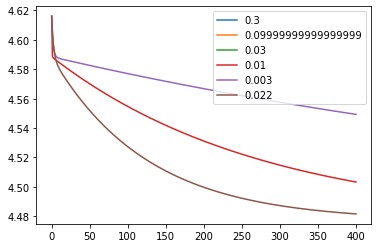

In [198]:

def learning_rate_gen(start=3):
    current_rate = start
    while True:
        yield current_rate
        yield current_rate / 3
        current_rate /= 10


ITERATIONS_LIMIT = 400

# Начальные значения параметров
THETA_0_START = DATA_TYPE("-5.")
THETA_1_START = DATA_TYPE("1.33")
LOSS_START = loss(THETA_0_START, THETA_1_START, POPULATIONS, PROFITS)


def learning_rate_graph(learning_rate):
    loss_values = [LOSS_START]
    for theta_0, theta_1 in itertools.islice(
        new_params_gen(
            THETA_0_START, THETA_1_START, POPULATIONS, PROFITS, learning_rate
        ),
        ITERATIONS_LIMIT,
    ):
        loss_value = loss(theta_0, theta_1, POPULATIONS, PROFITS)
        # Ограничение для читабельности графика
        if loss_value > LOSS_START:
            break
        loss_values.append(loss_value)

    plt.plot(list(range(len(loss_values))), loss_values, label=str(learning_rate))


for learning_rate in itertools.islice(learning_rate_gen(0.3), 5):
    learning_rate_graph(learning_rate)

# Оптимальный коэффициент скорости обучения
LEARNING_RATE = DATA_TYPE("0.022")
learning_rate_graph(LEARNING_RATE)

plt.legend()
plt.show()

## Поиск подходящей модели

In [199]:
theta_0, theta_1, iterations = gradient_descent(
    THETA_0_START,
    THETA_1_START,
    x=POPULATIONS,
    y=PROFITS,
    learning_rate=DATA_TYPE("0.022"),
    precision=0.001,
    max_iterations=20000,
)

print(
    f"theta_0 = {theta_0}, theta_1 = {theta_1}, "
    f"MSE = {loss(theta_0, theta_1, POPULATIONS, PROFITS)}, "
    f"{iterations} iterations"
)

theta_0 = -4.146194085970259, theta_1 = 1.218190383513896, MSE = 4.482679930746217, 374 iterations


### Вывод результатов

In [200]:
approximation_axes.plot(
    POPULATIONS, [hypothesis(theta_0, theta_1, x) for x in POPULATIONS], color="red"
)

approximation_fig

## Зависимость функции потерь от параметров

In [201]:
MESH_SPREAD = DATA_TYPE("20.0")
MESH_STEP_COUNT = 50

theta_0_values = np.linspace(
    theta_0 - MESH_SPREAD, theta_0 + MESH_SPREAD, num=MESH_STEP_COUNT, dtype=DATA_TYPE
)
theta_1_values = np.linspace(
    theta_1 - MESH_SPREAD, theta_1 + MESH_SPREAD, num=MESH_STEP_COUNT, dtype=DATA_TYPE
)

theta_0_values, theta_1_values = np.meshgrid(theta_0_values, theta_1_values)

loss_values = np.empty((MESH_STEP_COUNT, MESH_STEP_COUNT), dtype=DATA_TYPE)

for i, (t0s, t1s) in enumerate(zip(theta_0_values, theta_1_values)):
    for j, (t0, t1) in enumerate(zip(t0s, t1s)):
        loss_values[i, j] = loss(t0, t1, POPULATIONS, PROFITS)

### 3D-поверхность

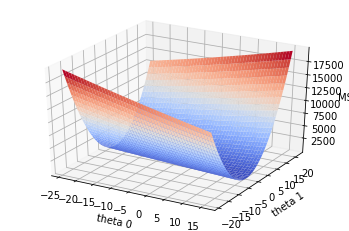

In [202]:
surface_fig = plt.figure()
loss_surface_axes = surface_fig.add_subplot(1, 1, 1, projection="3d")

surface = loss_surface_axes.plot_surface(
    theta_0_values, theta_1_values, loss_values, cmap=cm.coolwarm
)

loss_surface_axes.set_xlabel("theta 0")
loss_surface_axes.set_ylabel("theta 1")
loss_surface_axes.set_zlabel("MSE")

plt.show()

### Контурный график

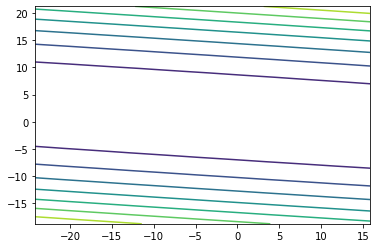

In [203]:
contour_fig = plt.figure()
loss_contour_axes = contour_fig.add_subplot(1, 1, 1)

contour = loss_contour_axes.contour(theta_0_values, theta_1_values, loss_values)

plt.show()